In [1]:
# –––– Import packages ––––
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

import tensorflow_addons as tfa
from PIL import Image
from PIL import ImageShow
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pathlib

import numpy as np
import copy

In [2]:
# –––– Import Datasets ––––
pic_dir = f"{os.getcwd()}/dataset/pictures/european_cities"
paint_dir = f"{os.getcwd()}/dataset/paintings/impressionist_landscapes_resized_1024"

In [3]:
def load_dataset(directory, max):
    ds = []
    count = 0
    for image in os.listdir(directory):
        ds.append(tf.keras.utils.load_img(f"{directory}/{image}"))
        count += 1
        if count==max: break
    return ds

In [4]:
pic_ds = load_dataset(pic_dir, 2000)

/Users/avascharfstein/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:3077: DecompressionBombWarning: Image size (91293606 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [5]:
paint_ds = load_dataset(paint_dir, len(pic_ds))

In [6]:
PIC_DATASET_SIZE = len(pic_ds)
PAINT_DATASET_SIZE = len(paint_ds)
print(PIC_DATASET_SIZE)
print(PAINT_DATASET_SIZE)

1923
1923


In [7]:
pic_train_size = int(0.7 * PIC_DATASET_SIZE)
pic_test_size = int(0.3 * PIC_DATASET_SIZE)
paint_train_size = int(0.7 * PAINT_DATASET_SIZE)
paint_test_size = int(0.3 * PAINT_DATASET_SIZE)

### TODO: shuffle the data before splitting into train and test sets

### TODO: split data into batches for epochs

In [8]:
pic_train = pic_ds[:pic_train_size]
pic_test = pic_ds[pic_train_size:]
paint_train = paint_ds[:paint_train_size]
paint_test = paint_ds[paint_train_size:]

In [9]:
len(pic_train)+len(pic_test)==PIC_DATASET_SIZE

True

In [10]:
len(paint_train)+len(paint_test)==PAINT_DATASET_SIZE

True

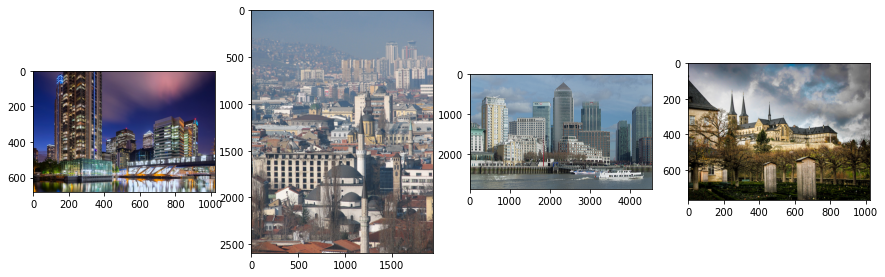

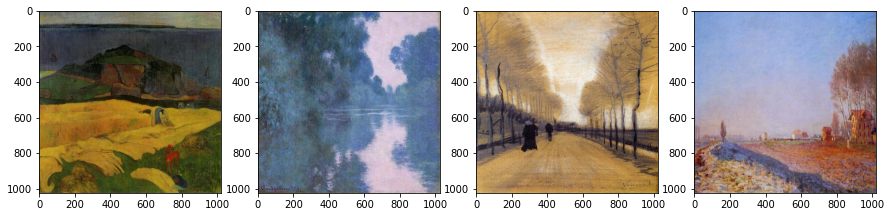

In [11]:
plt.figure(figsize=(15,15))
for i, img in enumerate(pic_ds[0:4]):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
plt.show()

plt.figure(figsize=(15,15))
for i, img in enumerate(paint_ds[0:4]):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    
plt.show()

### TODO: FIgure out how to normalize (?), random crop? --> not even sure if this is necessary though

In [12]:
import random

# For resizing the images
IMG_HEIGHT = 256
IMG_WIDTH = 256

def resize(image):
    return image.resize((IMG_HEIGHT, IMG_WIDTH))

# normalizing the images to [-1, 1]
# def normalize(image):
#     return image.point(lambda i: (float(i)/127.5) - 1)

# def denormalize(image):
#     image = tf.cast(image, tf.float32)
#     image = (image * 0.5 + 0.5) * 255 # Range 0 to 1 and then to range 0..255
#     image = tf.cast(image, tf.int32)
#     return image

def random_crop(image, target_size): # assume square
    img_size = image.size
    x_max = img_size[0] - target_size
    y_max = img_size[1] - target_size

    random_x = random.randrange(0, x_max//2 + 1) * 2
    random_y = random.randrange(0, y_max//2 + 1) * 2

    area = (random_x, random_y, random_x + target_size, random_y + target_size)
    return image.crop(area)

def random_jitter(image): # idk if this is the best method
    # resizing to 400 x 400
    image = image.resize((400, 400))

    # randomly cropping to 256 x 256
    image = random_crop(image,256)

    # random mirroring

    return image

def random_mirror(image):
    if random.randint(0, 1):
        image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    return image

def preprocess_image_train(image):
    image = resize(image)
    #image = random_jitter(image)
    #image = normalize(image)
    image = random_mirror(image)
    return image

def preprocess_image_test(image):
    image = resize(image)
    #image = normalize(image)
    return image

Preprocessing steps for picture:
1. Resize Image to 256 x 256
2. Random Mirror of Image

Picture before and after pre-processing

In [13]:
pic_ex_og = pic_train[0]
pic_ex_pp = preprocess_image_train(pic_train[0])

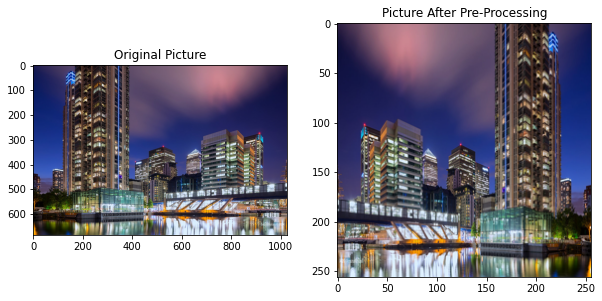

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(pic_ex_og)
plt.title("Original Picture")
plt.subplot(1,2,2)
plt.imshow(pic_ex_pp)
plt.title("Picture After Pre-Processing");

Painting before and after pre-processing

In [15]:
paint_ex_og = paint_train[0]
paint_ex_pp = resize(paint_train[0])

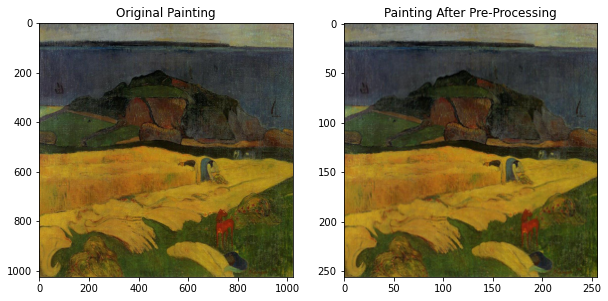

In [16]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(paint_ex_og)
plt.title("Original Painting")
plt.subplot(1,2,2)
plt.imshow(paint_ex_pp)
plt.title("Painting After Pre-Processing");

In [17]:
pic_train = [preprocess_image_train(img) for img in pic_train]

In [18]:
pic_test = [preprocess_image_test(img) for img in pic_test]

In [19]:
paint_train = [resize(img) for img in paint_train] 

In [20]:
paint_test = [resize(img) for img in paint_test]

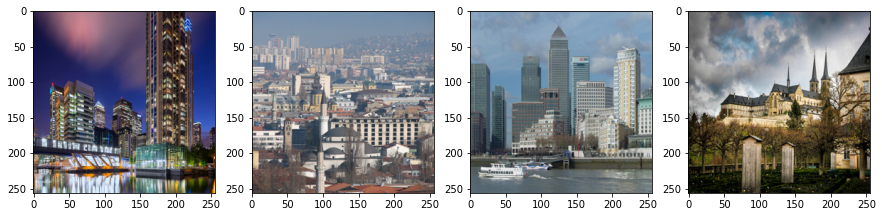

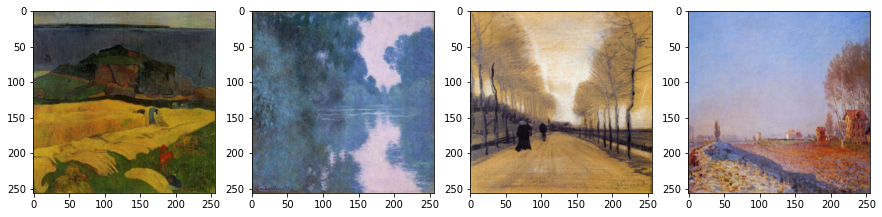

In [21]:
plt.figure(figsize=(15,15))
for i, img in enumerate(pic_train[0:4]):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
plt.show()

plt.figure(figsize=(15,15))
for i, img in enumerate(paint_train[0:4]):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    
plt.show()

Now must convert all of the Pil Images to Tensors. Let x represent the pictures and y represent the paintings

run code on collab or kaggle
how to use gpus on this platform

In [22]:
transform = transforms.Compose([transforms.PILToTensor()])

In [ ]:
xtrain = [transform(img) for img in pic_train]

In [ ]:
ytrain = [transform(img) for img in paint_train]

In [ ]:
xtest = [transform(img) for img in pic_test]

In [ ]:
ytest = [transform(img) for img in paint_test]

In [ ]:
# https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [ ]:
xsample = next(batch(xtrain))
ysample = next(batch(ytrain))

BUILDING THE MODEL

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
# Let x be the pictures and y be the paintings
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_y = generator_g(xsample)
to_x = generator_f(ysample)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [xsample, to_paint, sample_paint, to_pic]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()